In [9]:
from pyomo.environ import ConcreteModel, Var, Objective, Constraint, SolverFactory, Binary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time


In [10]:
def carregar_instancia(csv_file):

    df = pd.read_csv(csv_file)

    if 'Item' in df.columns and 'Valor' in df.columns:
        cap_row = df[df['Item'].str.lower() == 'capacidade']
        if not cap_row.empty:
            capacity = float(cap_row['Valor'].values[0])
            df = df[df['Item'].str.lower() != 'capacidade']
        else:
            capacity = 5.0
    else:
        capacity = 5.0

    items = df['Item'].tolist()
    values = df['Valor'].tolist()
    weights = df['Peso'].tolist()

    return items, values, weights, capacity


In [11]:
def resolver_mochila(items, values, weights, capacity):
    model = ConcreteModel()
    model.x = Var(items, domain=Binary)

    # Função objetivo
    model.obj = Objective(expr=sum(values[i] * model.x[items[i]] for i in range(len(items))),
                          sense='maximize')

    # Restrição de capacidade
    model.capacity_constraint = Constraint(expr=sum(weights[i] * model.x[items[i]] for i in range(len(items))) <= capacity)

    solver = SolverFactory('glpk')
    start_time = time.time()
    solver.solve(model)
    elapsed_time = time.time() - start_time

    # Extrair resultados
    results = pd.DataFrame({
        'Item': items,
        'Valor': values,
        'Peso': weights,
        'Selecionado': [model.x[item].value for item in items]
    })

    total_value = sum(values[i] * model.x[items[i]].value for i in range(len(items)))

    return results, total_value, elapsed_time

In [12]:
instancias = ['data/C2.csv', 'data/C3.csv', 'data/C4.csv']
comparativo = []

for csv_file in instancias:
    items, values, weights, capacity = carregar_instancia(csv_file)
    results, total_value, tempo = resolver_mochila(items, values, weights, capacity)

    comparativo.append({
        'Instancia': csv_file,
        'Num_itens': len(items),
        'Capacidade': capacity,
        'Valor_total': total_value,
        'Tempo_segundos': tempo
    })

    print(f"\nResultados para {csv_file}:")
    print(results)
    print(f"Valor total: {total_value} R$, Tempo: {tempo:.4f}s")


Resultados para data/C1.csv:
                  Item  Valor  Peso  Selecionado
0       Notebook Gamer   7500   2.8          1.0
1          Câmera DSLR   4200   1.9          1.0
2               Tablet   2300   0.7          0.0
3       Fone Bluetooth    800   0.3          1.0
4                Livro    350   1.2          0.0
5  Carregador Portátil    600   0.4          0.0
Valor total: 12500.0 R$, Tempo: 0.0365s

Resultados para data/C2.csv:
                  Item   Valor  Peso  Selecionado
0       Notebook Gamer  7500.0   2.8          1.0
1          Câmera DSLR  4200.0   1.9          1.0
2               Tablet  2300.0   0.7          1.0
3       Fone Bluetooth   800.0   0.3          1.0
4                Livro   350.0   1.2          0.0
5  Carregador Portátil   600.0   0.4          1.0
6           Smartwatch  1200.0   0.2          1.0
7           Headphones  1500.0   0.5          1.0
Valor total: 18100.0 R$, Tempo: 0.0614s

Resultados para data/C3.csv:
                  Item   Valor  Peso 

In [13]:
comparativo_df = pd.DataFrame(comparativo)
print("\nComparativo entre instâncias:")
print(comparativo_df)


Comparativo entre instâncias:
     Instancia  Num_itens  Capacidade  Valor_total  Tempo_segundos
0  data/C1.csv          6         5.0      12500.0        0.036450
1  data/C2.csv          8         7.0      18100.0        0.061376
2  data/C3.csv          4         2.0       3700.0        0.048136
3  data/C4.csv          6         6.0      14800.0        0.037511


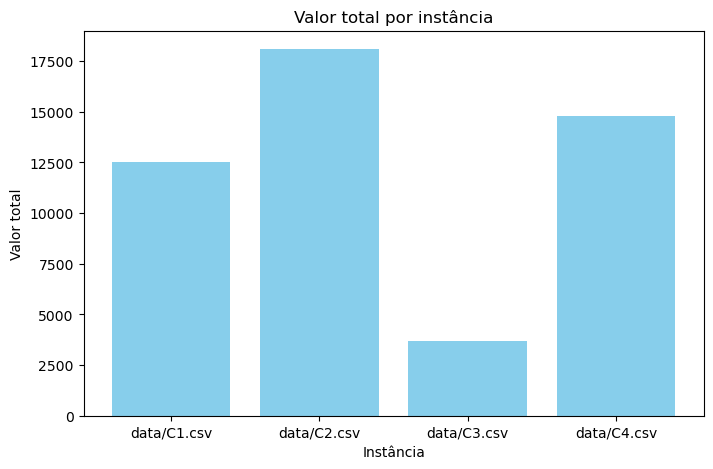

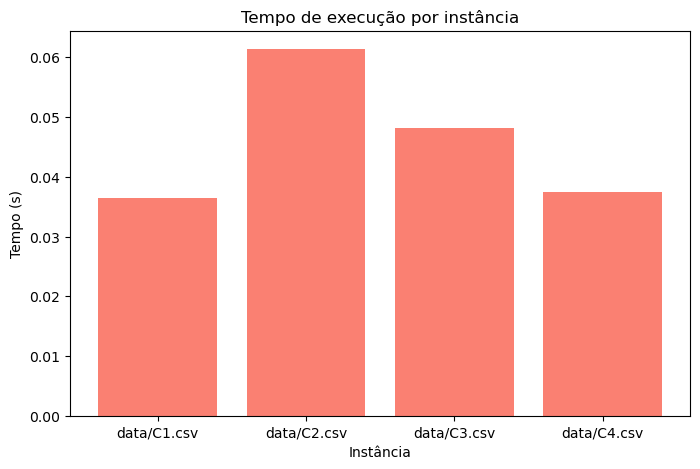

In [14]:
plt.figure(figsize=(8,5))
plt.bar(comparativo_df['Instancia'], comparativo_df['Valor_total'], color='skyblue')
plt.title('Valor total por instância')
plt.xlabel('Instância')
plt.ylabel('Valor total')
plt.show()

plt.figure(figsize=(8,5))
plt.bar(comparativo_df['Instancia'], comparativo_df['Tempo_segundos'], color='salmon')
plt.title('Tempo de execução por instância')
plt.xlabel('Instância')
plt.ylabel('Tempo (s)')
plt.show()